# Preprocessing

In [32]:
#Setting
import psycopg2
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [3]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')

In [46]:
#비지도 학습 모델링을 위하여 우선적으로 price를 제외한 나머지 정보만 Dataframe으로 만드릭
df = (apartment.
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left',on='apartment_id'))

In [47]:
#NA 값 확인
df.isnull().sum()

district_id              0
apartment_id             0
apartment_addr_town      0
apartment_builder        0
apartment_build_year     0
apartment_build_month    0
apartment_floor_min      0
apartment_floor_max      0
apartment_parking        0
district_name            0
school_name              0
school_dist              0
school_addr_district     0
school_addr_town         0
school_students          0
st_name                  0
st_dist                  0
st_volume                0
dtype: int64

In [48]:
#전반적인 내용 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8016 entries, 0 to 8015
Data columns (total 18 columns):
district_id              8016 non-null int64
apartment_id             8016 non-null int64
apartment_addr_town      8016 non-null object
apartment_builder        8016 non-null object
apartment_build_year     8016 non-null int64
apartment_build_month    8016 non-null int64
apartment_floor_min      8016 non-null object
apartment_floor_max      8016 non-null object
apartment_parking        8016 non-null float64
district_name            8016 non-null object
school_name              8016 non-null object
school_dist              8016 non-null int64
school_addr_district     8016 non-null int64
school_addr_town         8016 non-null object
school_students          8016 non-null object
st_name                  8016 non-null object
st_dist                  8016 non-null float64
st_volume                8016 non-null int64
dtypes: float64(2), int64(7), object(9)
memory usage: 1.2+ MB


In [107]:
#아파트 층수와 학생수를 int로 바꾼다
df['apartment_floor_min'] = pd.to_numeric(df['apartment_floor_min'])
df['apartment_floor_max'] = pd.to_numeric(df['apartment_floor_max'])
df['school_students'] = pd.to_numeric(df['school_students'])


In [49]:
#우선적으로 이제 필요 없어진 district_id, aparment_id를 제거하기로 한다.
df = df.drop(['district_id','apartment_id'],axis=1)

In [50]:
#아파트 준공 년,월을 합쳐주기로 하고, 해당 열도 지운다
import datetime
df['apartment_build_date'] = pd.to_datetime(df.apartment_build_year.astype(str) + '/' + df.apartment_build_month.astype(str) + '/01')
df = df.drop(['apartment_build_year','apartment_build_month'],axis=1)

In [51]:
#school_addr_town에서 이상하게 뒤에 ~길 붙는 내용들은 모두 삭제하고 깔끔하게 ~로까지만 확인한다
import re
df['school_addr_town'] = df['school_addr_town'].apply(lambda x: re.split('\d',x)[0])

In [52]:
df.head(15)
#null 값이 없는 줄 알았는데, 확인해보니 근처 학교가 없는 곳이 있다. 이는 ''로 표기 되어 있으며, df == '' 로 확인하면 나온다.
#다만 어차피 clustering을 진행할 것이기 때문에 그냥 놔두기로 한다. 

,apartment_addr_town,apartment_builder,apartment_floor_min,apartment_floor_max,apartment_parking,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume,apartment_build_date
0,개포동,LG건설(주),20,22,2.36,강남구,서울대진초등학교,1,1,개포로,316,학여울역,0.002592,1,2004-06-01
1,개포동,삼성물산(주),7,35,1.71,강남구,서울구룡초등학교,2,1,개포로,492,매봉역,0.009325,1,2020-09-01
2,개포동,상지건영(주),10,10,2.27,강남구,서울개일초등학교,4,1,개포로,837,구룡역,0.002699,1,2003-03-01
3,개포동,대한주택공사,5,5,0.49,강남구,서울개원초등학교,1,1,선릉로,131,구룡역,0.007869,1,1982-11-01
4,개포동,대한주택공사,5,5,0.40,강남구,서울양전초등학교,1,1,개포로,455,개포동역,0.004453,1,1982-11-01
5,개포동,대한주택공사,13,14,0.97,강남구,서울양전초등학교,3,1,개포로,455,개포동역,0.001978,1,1983-10-01
6,개포동,대한주택공사,13,15,0.28,강남구,서울양전초등학교,2,1,개포로,455,개포동역,0.001076,1,1983-10-01
7,개포동,대한주택공사,15,15,0.44,강남구,서울양전초등학교,2,1,개포로,455,개포동역,0.002930,1,1983-10-01
8,개포동,㈜GS건설,7,35,1.74,강남구,,0,1,,,개포동역,0.004421,1,2023-02-01
9,개포동,현대건설,9,9,0.00,강남구,서울구룡초등학교,1,1,개포로,492,매봉역,0.005728,1,1986-07-01


# EDA

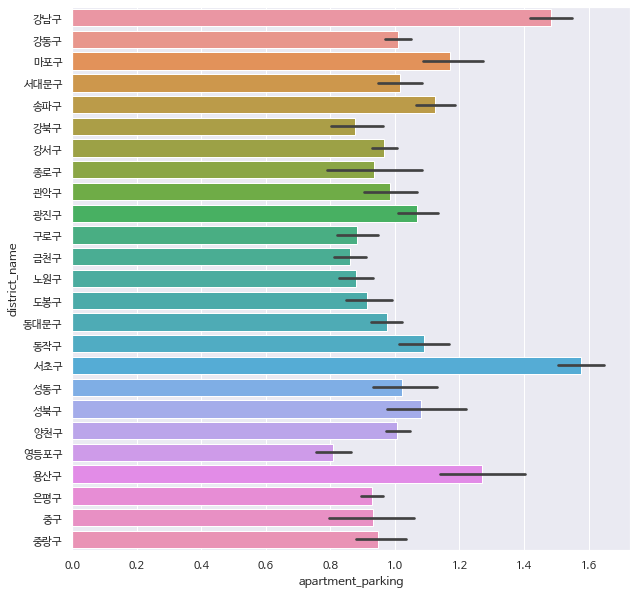

In [61]:
#폰트 설정
import matplotlib.font_manager as fm

path = '/Library/Fonts/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

#주소와 주차장수 관계
sns.barplot(x='apartment_parking',y='district_name',data=df)

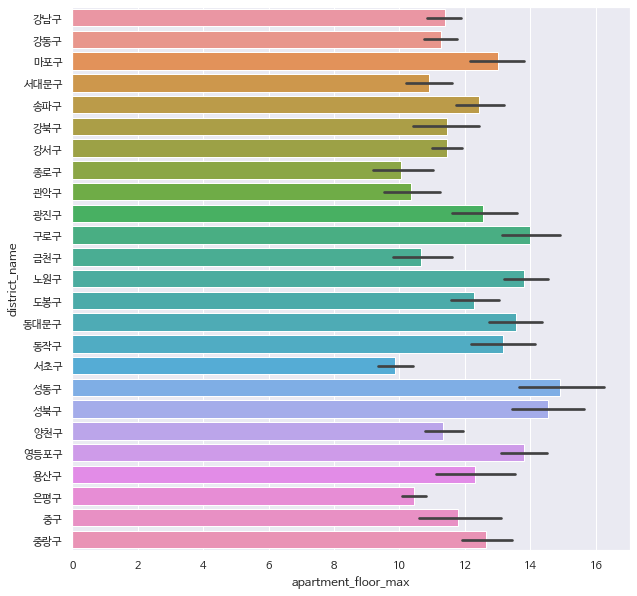

In [99]:
#주소와 층 수 관계
sns.barplot(x='apartment_floor_max',y='district_name',data=df)

(5.0, 0.0)

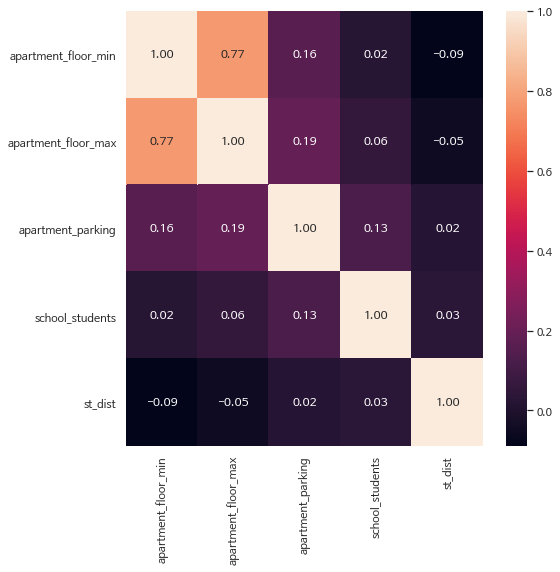

In [119]:
#숫자형 자료 간의 상관관계
temp = df[['apartment_floor_min','apartment_floor_max','apartment_parking','school_students','st_dist']]
temp
plt.subplots(figsize=(8,8))

ax = sns.heatmap(data=temp.corr(),annot=True,fmt='.2f')
buttom,top = ax.get_ylim()
ax.set_ylim(buttom+0.5,top-0.5)

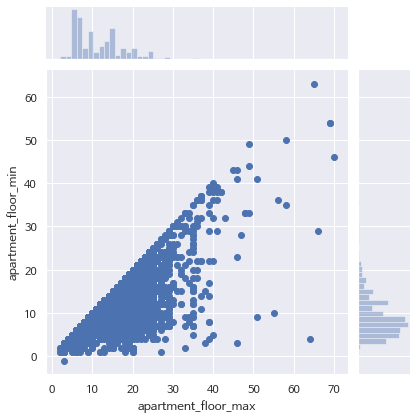

In [124]:
#max / min 사이에는 전처리가 필요해보인다
sns.jointplot(x = 'apartment_floor_max', y = 'apartment_floor_min', data = df)

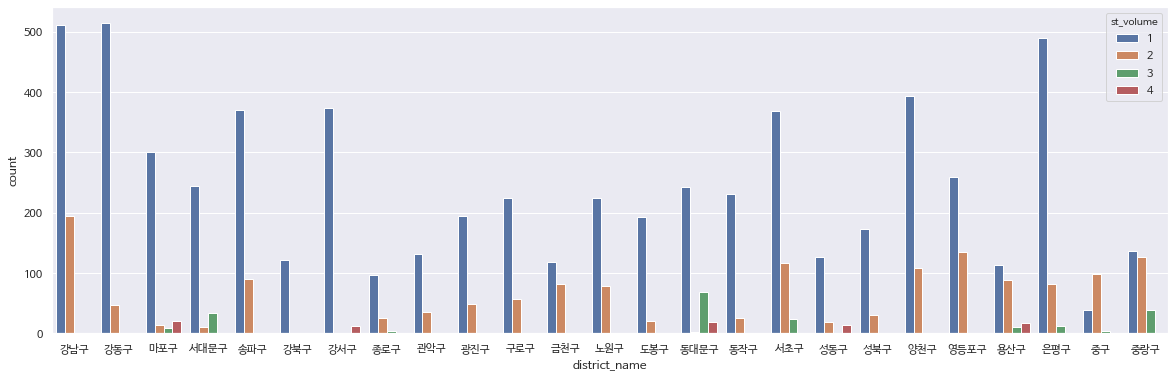

In [122]:
#지역별 지하철역 개수 확인

sns.countplot(x = 'district_name', data = df, hue = 'st_volume')